# Set-Up

In [1]:
!pip3 install datasets
!pip install accelerate -U

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import transformers
from transformers import DefaultDataCollator, Trainer, TrainingArguments, EarlyStoppingCallback, BeitImageProcessor, BeitForImageClassification
# ViTImageProcessor, ViTForImageClassification, AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset, load_metric, DatasetDict
from PIL import Image
import accelerate
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

#try:
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    print('Device:', tpu.master())
#    tf.config.experimental_connect_to_cluster(tpu)
#    tf.tpu.experimental.initialize_tpu_system(tpu)
#    strategy = tf.distribute.experimental.TPUStrategy(tpu)
#except:
#    strategy = tf.distribute.get_strategy()
#print('Number of replicas:', strategy.num_replicas_in_sync)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 9.7 M

# Variables globales

In [2]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#EPOCHS = 100

# Importar datos

In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/kaggle"

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: /kaggle/Alzhe

# Cargar datos

In [4]:
checkpoint = "microsoft/beit-base-patch16-224-pt22k-ft22k"
#checkpoint = "google/vit-base-patch16-224-in21k"

dataset = load_dataset("imagefolder", data_dir="/kaggle/Alzheimer_s Dataset")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# test_valid = dataset["test"].train_test_split(test_size=0.5)
# dataset = DatasetDict({
#     'train': dataset['train'],
#     'test': test_valid['test'],
#     'valid': test_valid['train']})

print(labels)
print(dataset.column_names)

Resolving data files:   0%|          | 0/5121 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
{'train': ['image', 'label'], 'test': ['image', 'label']}


# Visualizar los datos

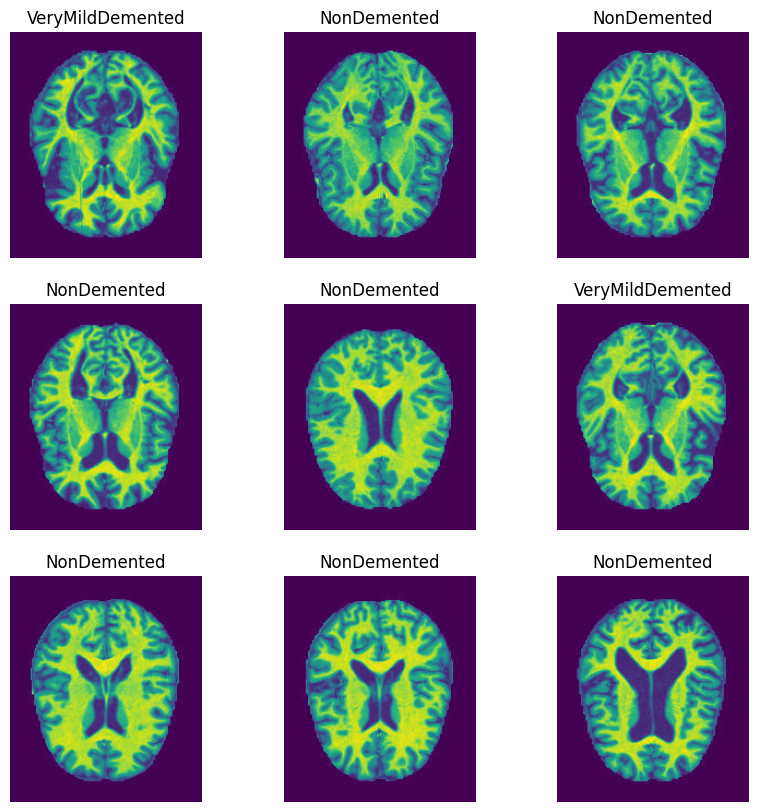

In [5]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(dataset["train"]) - 1)
    ax = plt.subplot(3, 3, i + 1)
    img = dataset["train"][index]["image"]
    label = id2label[str(dataset["train"][index]["label"])]
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

# Preprocesamiento de los datos

In [6]:
#image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor = BeitImageProcessor.from_pretrained(checkpoint)

# normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
# size = (
#     image_processor.size["shortest_edge"]
#     if "shortest_edge" in image_processor.size
#     else (image_processor.size["height"], image_processor.size["width"])
# )

# _transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

# def transforms(examples):
#     examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
#     del examples["image"]
#     return examples

# dataset = dataset.with_transform(transforms)
# data_collator = DefaultDataCollator()

def process_example(example):
    inputs = image_processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

def transform(example_batch):
    # Convert images to RGB if they are not already in RGB
    images = [img.convert("RGB") if img.mode != "RGB" else img for img in example_batch['image']]

    # Use the image processor to convert the images to the required format (pixel values as PyTorch tensors)
    inputs = image_processor(images, return_tensors='pt')

    # Use the correct key for labels
    inputs['labels'] = example_batch['label']

    return inputs

proc_dataset = dataset.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

#print(dataset['train'][3])
#print(transform(dataset['train'][3:6]))
#print(process_example(dataset['train'][3])['pixel_values'].shape)
#print(proc_dataset['train'][3])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


# Exploración de los datos

# Modelo

In [ ]:
#BUENO
#model = AutoModelForImageClassification.from_pretrained(
model = BeitForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    #trust_remote_code=True
)

model = model.to(device)

#metric = load_metric("accuracy")

#def compute_metrics(eval_pred):
#    logits, labels = eval_pred
#    predictions = np.argmax(logits, axis=-1)
#    return metric.compute(predictions=predictions, references=labels)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.05)

# training_args = TrainingArguments(
#     output_dir="/home/results",
#     remove_unused_columns=False,
#     #eval_strategy="epoch",
#     eval_strategy="steps",
#     #save_strategy="epoch",
#     eval_steps = 50,
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=10,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1"
# )

training_args = TrainingArguments(
    output_dir="/home/results",               # Directorio de salida
    learning_rate=5e-6,                   # Tasa de aprendizaje
    per_device_train_batch_size=16,        # Tamaño del batch de entrenamiento por dispositivo
    per_device_eval_batch_size=16,         # Tamaño del batch de evaluación por dispositivo
    num_train_epochs=20,                  # Número de épocas
    seed=42,                              # Semilla para la reproducibilidad
    gradient_accumulation_steps=1,        # Acumulación de gradientes
    eval_strategy="epoch",          # Estrategia de evaluación (aquí se evalúa cada época)
    lr_scheduler_type="cosine",           # Tipo de scheduler de la tasa de aprendizaje
    warmup_ratio=0.1,                     # Ratio de warmup del scheduler
    logging_dir='/home/logs',                 # Directorio para los logs
    logging_steps=10,                     # Frecuencia de los logs
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch",
    #warmup_steps=10,
    #total_train_batch_size = 64,
)

# Configurar el optimizador Adam con los betas especificados
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-6,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.5,
    amsgrad=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    #data_collator=data_collator,
    data_collator=collate_fn,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    #eval_dataset=dataset["valid"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=5)],
    callbacks=[early_stopper],
    optimizers=(optimizer, None)
)

history = trainer.train()

trainer.evaluate(eval_dataset=proc_dataset['test'])

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.891600,0.936266,0.572322,0.614869,0.572322,0.540587
2,0.608100,0.980045,0.531665,0.694566,0.531665,0.508874
3,0.372400,0.881724,0.623143,0.625615,0.623143,0.589127
4,0.125600,0.982365,0.634871,0.670228,0.634871,0.639161
5,0.039600,1.663960,0.606724,0.743814,0.606724,0.593924
6,0.047800,1.407126,0.716966,0.715333,0.716966,0.706179


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

In [10]:
trainer.evaluate(eval_dataset=proc_dataset['train'])

{'eval_loss': 0.026083149015903473,
 'eval_accuracy': 0.9927748486623706,
 'eval_precision': 0.9930125052271032,
 'eval_recall': 0.9927748486623706,
 'eval_f1': 0.9927960197648312,
 'eval_runtime': 79.4289,
 'eval_samples_per_second': 64.473,
 'eval_steps_per_second': 4.041,
 'epoch': 7.0}

In [ ]:
#processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
#model = AutoModelForImageClassification.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

model = AutoModelForImageClassification.from_pretrained(
#model = BeitForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
    output_dir='/home/results',      # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/var/log/model',    # directory for storing logs
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset["train"],      # training dataset
    eval_dataset=dataset["test"]         # evaluation dataset
)

trainer.train()
trainer.evaluate()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyError: 'image'

# Añadir más datos (data augmentation)

In [ ]:
size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

dataset["train"].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

data_collator = DefaultDataCollator(return_tensors="tf")